# Connecter le drive et le colab

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.listdir()
#cwd = os.getcwd()
#print(cwd)
#!ls gdrive/MyDrive
#os.listdir()
path = "/content/gdrive/MyDrive"
os.chdir(path)df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_19102021.pkl")
cwd = os.getcwd()
print(cwd)

print(os.listdir())

/content/gdrive/MyDrive
['sample_data', 'Colab Notebooks', '.ipynb_checkpoints', 'data', 'saves', 'Images_&_Iteration_#1_LeNet.ipynb']


**Import packages**

In [123]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import re
tqdm_notebook.pandas()
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
import pickle
from joblib import dump, load

# Identification of product classes

 ***Create xtrain , xtest and ytrain DataFrames from csv files***

In [77]:
df_xtrain = pd.read_csv('./data/texts/X_train_update.csv') 

In [78]:
df_xtest = pd.read_csv('./data/texts/X_test_update.csv') 

In [79]:
df_ytrain = pd.read_csv('./data/texts/Y_train_CVw08PX.csv') 

In [80]:
print("df_xtrain shape: ", df_xtrain.shape)
print("df_xtest shape: ", df_xtest.shape)
print("df_ytrain shape: ", df_ytrain.shape)

df_xtrain shape:  (84916, 5)
df_xtest shape:  (13812, 5)
df_ytrain shape:  (84916, 2)


In [81]:
df_xtrain.head()

,Unnamed: 0,designation,description,productid,imageid
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


In [82]:
df_xtest.head()

,Unnamed: 0,designation,description,productid,imageid
0,84916,Folkmanis Puppets - 2732 - Marionnette Et Théâ...,NaN,516376098,1019294171
1,84917,Porte Flamme Gaxix - Flamebringer Gaxix - 136/...,NaN,133389013,1274228667
2,84918,Pompe de filtration Speck Badu 95,NaN,4128438366,1295960357
3,84919,Robot de piscine électrique,<p>Ce robot de piscine d&#39;un design innovan...,3929899732,1265224052
4,84920,Hsm Destructeur Securio C16 Coupe Crois¿E: 4 X...,NaN,152993898,940543690


In [83]:
df_ytrain.head()

,Unnamed: 0,prdtypecode
0,0,10
1,1,2280
2,2,50
3,3,1280
4,4,2705


In [84]:
# Nan values
null_counts = df_xtrain.isnull().sum().sort_values(ascending=False)
print('df_xtrain: \n', null_counts[null_counts > 0])

null_counts = df_xtest.isnull().sum().sort_values(ascending=False)
print(' \n df_xtest: \n',null_counts[null_counts > 0])

null_counts = df_ytrain.isnull().sum().sort_values(ascending=False)
print(' \ndf_ytrain: \n',null_counts[null_counts > 0])

df_xtrain: 
 description    29800
dtype: int64
 
 df_xtest: 
 description    4886
dtype: int64
 
df_ytrain: 
 Series([], dtype: int64)


In [85]:
display(df_ytrain["prdtypecode"].unique())

unique, counts = np.unique(df_ytrain["prdtypecode"], return_counts=True)
dict(zip(unique, counts))

array([  10, 2280,   50, 1280, 2705, 2522, 2582, 1560, 1281, 1920, 2403,
       1140, 2583, 1180, 1300, 2462, 1160, 2060,   40,   60, 1320, 1302,
       2220, 2905, 2585, 1940, 1301], dtype=int64)

{10: 3116,
 40: 2508,
 50: 1681,
 60: 832,
 1140: 2671,
 1160: 3953,
 1180: 764,
 1280: 4870,
 1281: 2070,
 1300: 5045,
 1301: 807,
 1302: 2491,
 1320: 3241,
 1560: 5073,
 1920: 4303,
 1940: 803,
 2060: 4993,
 2220: 824,
 2280: 4760,
 2403: 4774,
 2462: 1421,
 2522: 4989,
 2582: 2589,
 2583: 10209,
 2585: 2496,
 2705: 2761,
 2905: 872}

In [86]:
df_ytrain["prdtypecode"].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

2583    12.02%
1560     5.97%
1300     5.94%
2060     5.88%
2522     5.88%
1280     5.74%
2403     5.62%
2280     5.61%
1920     5.07%
1160     4.66%
1320     3.82%
10       3.67%
2705     3.25%
1140     3.15%
2582     3.05%
40       2.95%
2585     2.94%
1302     2.93%
1281     2.44%
50       1.98%
2462     1.67%
2905     1.03%
60       0.98%
2220     0.97%
1301     0.95%
1940     0.95%
1180      0.9%
Name: prdtypecode, dtype: object

 ***Concatenate  df_xtrain and df_ytrain(to get product code type(Classes))***

In [87]:
# Sort des deux DF avant de faire la concaténation
df_xtrain = df_xtrain.sort_values(by = 'Unnamed: 0', ascending = True)
df_ytrain = df_ytrain.sort_values(by = 'Unnamed: 0', ascending = True)

In [88]:
# Comparaison des deux colonnes 'Unnamed: 0' des deux DF df_xtrain et  df_ytrain
df_xtrain['Unnamed: 0'].isin(df_ytrain['Unnamed: 0']).value_counts()

True    84916
Name: Unnamed: 0, dtype: int64

In [89]:
# Concaténation des deux DF - Train
df_combined = pd.concat([df_xtrain, df_ytrain['prdtypecode'] ], axis = 1)
df_combined.drop('Unnamed: 0', axis =1 , inplace = True)

In [90]:
df_combined

,designation,description,productid,imageid,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705
...,...,...,...,...,...
84911,The Sims [ Import Anglais ],NaN,206719094,941495734,40
84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883,2583
84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617,2280
84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403,1560


In [91]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
 4   prdtypecode  84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB


In [92]:
df_combined.shape

(84916, 5)

***Get image name from product and image Id***

In [94]:
#path_im = "./data/images/all/image_train/"  # Train folder containing org image  500 x 500 
#path_im = "./data/images/all/image_train_resized/"  # Train folder containing resized  256 x 256 
#im_prfix = "image_"
im_prfix = "resized_image_"

#df_combined["imagePath"] =  path_im  + im_prfix  + df_combined.imageid.astype(str)+ "_product_" + df_combined.productid.astype(str) + ".jpg"
df_combined["imagePath"] =  im_prfix  + df_combined.imageid.astype(str)+ "_product_" + df_combined.productid.astype(str) + ".jpg"

In [95]:
df_combined

,designation,description,productid,imageid,prdtypecode,imagePath
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,resized_image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,resized_image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,resized_image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280,resized_image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,resized_image_1077757786_product_278535884.jpg
...,...,...,...,...,...,...
84911,The Sims [ Import Anglais ],NaN,206719094,941495734,40,resized_image_941495734_product_206719094.jpg
84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883,2583,resized_image_1188462883_product_3065095706.jpg
84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617,2280,resized_image_1009325617_product_440707564.jpg
84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403,1560,resized_image_1267353403_product_3942400296.jpg


# Dataframe saving to pickle and CSV files

In [96]:
from datetime import date
import xlwt
import openpyxl
pathSave = './saves/df_save/'

today = date.today()
version = '_V0'

# To pickle file
df_combined.to_pickle(f"{pathSave}/df_train_combined_19102021.pkl")

# To CSV file
df_combined.to_csv(f"{pathSave}/df_train_combined_19102021{today}{version}.csv")

# Iteration #1 -  VGG16

***Read DataFrame from saved pickele file - image Train set***

In [5]:
df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_19102021.pkl")

In [3]:
df_train_im

,designation,description,productid,imageid,prdtypecode,imagePath
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,resized_image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,resized_image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,resized_image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280,resized_image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,resized_image_1077757786_product_278535884.jpg
...,...,...,...,...,...,...
84911,The Sims [ Import Anglais ],NaN,206719094,941495734,40,resized_image_941495734_product_206719094.jpg
84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883,2583,resized_image_1188462883_product_3065095706.jpg
84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617,2280,resized_image_1009325617_product_440707564.jpg
84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403,1560,resized_image_1267353403_product_3942400296.jpg


In [4]:
display(df_train_im.shape)

(84916, 6)

In [5]:
#df_train_im = df_train_im.head(df_train_im.shape[0]//2)
#df_train_im = df_train_im.head(200)

In [6]:
display(df_train_im["prdtypecode"].unique())

array([  10, 2280,   50, 1280, 2705, 2522, 2582, 1560, 1281, 1920, 2403,
       1140, 2583, 1180, 1300, 2462, 1160, 2060,   40,   60, 1320, 1302,
       2220, 2905, 2585, 1940, 1301], dtype=int64)

***Change of product codes from 27 classes to 0 to 26***

In [7]:
df_train_im.replace({'prdtypecode':{10:0,
                                    40:1,
                                    50:2,
                                    60:3,
                                    1140:4,
                                    1160:5,
                                    1180:6,
                                    1280:7,
                                    1281:8,
                                    1300:9                                    
                                    }}, inplace = True)

df_train_im.replace({'prdtypecode':{1301:10,
                                    1302:11,
                                    1320:12,
                                    1560:13,
                                    1920:14,
                                    1940:15,
                                    2060:16,
                                    2220:17,
                                    2280:18,
                                    2403:19,
                                    2462:20,
                                    2522:21,
                                    2582:22,
                                    2583:23,
                                    2585:24,
                                    2705:25,
                                    2905:26
                                    }}, inplace = True)

In [8]:
display(df_train_im["prdtypecode"].unique())

array([ 0, 18,  2,  7, 25, 21, 22, 13,  8, 14, 19,  4, 23,  6,  9, 20,  5,
       16,  1,  3, 12, 11, 17, 26, 24, 15, 10], dtype=int64)

In [9]:
df_train_im

,designation,description,productid,imageid,prdtypecode,imagePath
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,0,resized_image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,18,resized_image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,2,resized_image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,7,resized_image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,25,resized_image_1077757786_product_278535884.jpg
...,...,...,...,...,...,...
84911,The Sims [ Import Anglais ],NaN,206719094,941495734,1,resized_image_941495734_product_206719094.jpg
84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883,23,resized_image_1188462883_product_3065095706.jpg
84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617,18,resized_image_1009325617_product_440707564.jpg
84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403,13,resized_image_1267353403_product_3942400296.jpg


 ***Split Train Set***

In [10]:
#X_train_im, X_valid_im = train_test_split(df_train_im, train_size=0.8, random_state=1234)

In [11]:
#display(X_train_im.shape)
#display(X_valid_im.shape)

***Data Generator***

In [12]:
df_train_im["prdtypecode"] = df_train_im["prdtypecode"].astype(str)

In [13]:
#X_train_im["prdtypecode"] = X_train_im["prdtypecode"].astype(str)
#X_valid_im["prdtypecode"] = X_valid_im["prdtypecode"].astype(str)


In [14]:
unique, counts = np.unique(df_train_im["prdtypecode"], return_counts=True)
dict(zip(unique, counts))

{'0': 3116,
 '1': 2508,
 '10': 807,
 '11': 2491,
 '12': 3241,
 '13': 5073,
 '14': 4303,
 '15': 803,
 '16': 4993,
 '17': 824,
 '18': 4760,
 '19': 4774,
 '2': 1681,
 '20': 1421,
 '21': 4989,
 '22': 2589,
 '23': 10209,
 '24': 2496,
 '25': 2761,
 '26': 872,
 '3': 832,
 '4': 2671,
 '5': 3953,
 '6': 764,
 '7': 4870,
 '8': 2070,
 '9': 5045}

In [15]:
%%time
#Générateur de données
img_gen = ImageDataGenerator(rescale = 1/255, 
                             validation_split = 0.2)

Wall time: 1e+03 µs


In [49]:
img_rows = 100
img_cols = 100
batch_size = 32
epochs = 6
images_dir_train = './data/images/all/image_train_resized/'

In [50]:
%%time

#Itérateur 
train_generator = img_gen.flow_from_dataframe(dataframe = df_train_im,
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                             
                                              target_size = (img_rows , img_cols), # default 256 x 256                                             
                                              batch_size = batch_size,                                             
                                              shuffle = True, # défault
                                              subset = 'training'
                                             )

Found 67933 validated image filenames belonging to 27 classes.
Wall time: 11.3 s


In [51]:
%%time
# validation_split the validation batches ca be retrieved by specifying the subset as validation.
valid_generator = img_gen.flow_from_dataframe(dataframe = df_train_im, 
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                        
                                              target_size = (img_rows , img_cols), # default 256 x 256                                         
                                              batch_size = batch_size, 
                                              shuffle = False,
                                              subset  = 'validation'
                                             )

Found 16983 validated image filenames belonging to 27 classes.
Wall time: 11.2 s


 ***VGG16 Implementation***

In [52]:
%%time
# Freez des chouche pré_entrainées d'Extraction de Features
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows,img_rows,3))
for layer in base_model.layers:
    layer.trainable = False

Wall time: 637 ms


In [53]:
# Architecture VGG16
model = Sequential()

# Ajout du modèle VGG16
model.add(base_model) 

# Ajout des couche de classification
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024,activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 512, activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 27, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 27)               

***Callbacks***

In [54]:
%%time
path = './saves/VGG16/'
file_name = 'checkpoint_VGG16_07112021-6Epochs.h5'

#Sauvegarder les meilleurs poids du modèle au cours de l'entraînement :
checkpoint = ModelCheckpoint(filepath = path + file_name , 
                             monitor ='val_accuracy',
                             verbose = 1,
                             save_best_only = True, # (pour que le meilleur modèle ne soit pas écrasé)
                             save_weights_only = False,
                             mode ='max', #(permet de préciser si la métrique doit croître ou décroitre : ici on choisit 'min'
                                           #car la métrique est une perte à minimiser)
                             save_freq='epoch')
#Arrêter l'entraînement si le modèle n'évolue plus (très pratique pour ne pas gérer le
#nombre d'epoch) :
early = EarlyStopping(monitor='val_loss',
                      min_delta = 0,
                      patience = 3, #(nombre d'epochs à attendre avant d'arrêter l'entraînement
                      restore_best_weights = True,
                      verbose = 1,
                      mode = 'min')



Wall time: 1 ms


 ***Modèle Compilation***

In [55]:
%%time
# Compilation
model.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation


Wall time: 21 ms


 ***Fit - train_generator***

In [56]:
step_size_Train = train_generator.n//train_generator.batch_size
step_size_Valid = valid_generator.n//valid_generator.batch_size
print('step_size_Train : ' , step_size_Train)
print('step_size_Valid  : ' , step_size_Valid)

step_size_Train :  2122
step_size_Valid  :  530


In [57]:
%%time
# Fit Train generator
history = model.fit(train_generator,                    
                    epochs = epochs,                   
                    steps_per_epoch = step_size_Train,
                    validation_data = valid_generator,
                    validation_steps = step_size_Valid,
                    callbacks=[checkpoint,early]
                    
                    )

Epoch 1/6
2122/2122 [==============================] - ETA: 0s - loss: 2.1059 - accuracy: 0.3811
Epoch 00001: val_accuracy improved from -inf to 0.42659, saving model to ./saves/VGG16\checkpoint_VGG16_07112021-6Epochs.h5
2122/2122 [==============================] - 10838s 5s/step - loss: 2.1059 - accuracy: 0.3811 - val_loss: 1.9489 - val_accuracy: 0.4266
Epoch 2/6
2122/2122 [==============================] - ETA: 0s - loss: 1.8696 - accuracy: 0.4467
Epoch 00002: val_accuracy improved from 0.42659 to 0.46716, saving model to ./saves/VGG16\checkpoint_VGG16_07112021-6Epochs.h5
2122/2122 [==============================] - 10863s 5s/step - loss: 1.8696 - accuracy: 0.4467 - val_loss: 1.8115 - val_accuracy: 0.4672
Epoch 3/6
2122/2122 [==============================] - ETA: 0s - loss: 1.7720 - accuracy: 0.4750
Epoch 00003: val_accuracy improved from 0.46716 to 0.47400, saving model to ./saves/VGG16\checkpoint_VGG16_07112021-6Epochs.h5
2122/2122 [==============================] - 10863s 5s/step

 ***Prediction - valid_generator***

In [58]:
%%time
#Prediction - Valid set
y_pred_proba = model.predict(valid_generator)

# l'argmax pour obtenir les classes prédites
y_pred_class = np.argmax(y_pred_proba,axis = 1).astype(int)

# To get classes from valid generator
y_true = valid_generator.classes

Wall time: 36min 27s


 ***Evaluation - valid_generator***

In [59]:
%%time
#Get the accuracy score
test_score = model.evaluate(valid_generator)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

531/531 [==============================] - 2308s 4s/step - loss: 1.6908 - accuracy: 0.4993
[INFO] accuracy: 49.93%
[INFO] Loss:  1.6907557249069214
Wall time: 38min 32s


In [60]:
print(metrics.classification_report(y_true, y_pred_class))
# Avg F1 score : 0.43

              precision    recall  f1-score   support

           0       0.51      0.40      0.45       621
           1       0.41      0.30      0.35       483
           2       0.48      0.38      0.43       154
           3       0.28      0.27      0.28       508
           4       0.40      0.27      0.32       656
           5       0.54      0.43      0.48      1038
           6       0.59      0.78      0.67       848
           7       0.38      0.49      0.43       152
           8       0.33      0.41      0.37      1021
           9       0.40      0.17      0.24       168
          10       0.55      0.65      0.60       956
          11       0.43      0.61      0.51       939
          12       0.43      0.19      0.26       375
          13       0.34      0.30      0.32       290
          14       0.54      0.56      0.55       949
          15       0.39      0.26      0.31       508
          16       0.67      0.75      0.71      2061
          17       0.32    

In [ ]:
unique, counts = np.unique(y_pred_class, return_counts=True)
dict(zip(unique, counts))

 ***Predict input image using trained model***

In [111]:
#Dictionary of prdtypecode and their corresponding categories
dict_prdtypecode = {"prdtypecode" : [50, 2705, 2522, 2582, 1560, 1281, 1920, 1280, 1140, 1300, 2060, 2583,
                                 60, 1320, 
               2280, 1302, 2220, 40, 2905, 2585, 1940, 1160, 1301, 10, 1180, 2403, 2462],
               "Label" : ["video games accessories", "books", "stationery", "kitchen and garden", 
           "interior furniture and bedding", "board games", "interior accessories",
                            "toys for children", 
           "goodies", "remote controlled models", "decoration interior", "piscine spa",
          "games and consoles", "early childhood", "magazines", "kids toys",
                            "supplies for domestic animals",
          "imported video games", "online distribution of video games", "gardening and DIY",
                            "Food",
          "playing cards", "accessories children", "adult books", "figurines_wargames", 
                            "children books",
          "games"]}
df_class = pd.DataFrame(data=dict_prdtypecode)
df_class

,prdtypecode,Label
0,50,video games accessories
1,2705,books
2,2522,stationery
3,2582,kitchen and garden
4,1560,interior furniture and bedding
5,1281,board games
6,1920,interior accessories
7,1280,toys for children
8,1140,goodies
9,1300,remote controlled models


In [112]:
# Crate DF containing prdtypecode , categories and corresponding class used by model
df_class = df_class.sort_values(by = 'prdtypecode', ascending = True)
df_class['target_prdtypecode'] = [i for i in range(27)]
df_class

,prdtypecode,Label,target_prdtypecode
23,10,adult books,0
17,40,imported video games,1
0,50,video games accessories,2
12,60,games and consoles,3
8,1140,goodies,4
21,1160,playing cards,5
24,1180,figurines_wargames,6
7,1280,toys for children,7
5,1281,board games,8
9,1300,remote controlled models,9


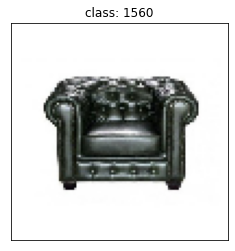

In [125]:
# Predict With Pre Trained

# Load an image
im_id = 11
img_path ='./data/images/all/image_train_resized/'+ df_train_im['imagePath'][im_id]

img = image.load_img(img_path,target_size=(100, 100))
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.title("class: " + str(df_train_im['prdtypecode'][im_id]))
plt.xticks([])
plt.yticks([])
#plt.axis('off')
plt.show();

In [126]:
im = cv2.resize(cv2.imread(img_path), (100, 100))
im = np.expand_dims(im, axis=0)

In [127]:
out = model.predict(im)
print("------------------Predicted Class and Label ------------------------------")
print("target class(used by model) :", np.argmax(out))
print("\n"  ,df_class[df_class['target_prdtypecode'] == np.argmax(out)][['prdtypecode', 'Label']].to_string(index=False)) 

prd_code = df_train_im['prdtypecode'][im_id]

print("\n\n------------------Real Class and Label ------------------------------")
print("target class(used by model): " ,  df_class[df_class['prdtypecode'] == prd_code]['target_prdtypecode'].to_string(index=False))
print("\n"  ,df_class[df_class['prdtypecode'] == prd_code][['prdtypecode', 'Label']].to_string(index=False)) 


 


------------------Predicted Class and Label ------------------------------
target class(used by model) : 12

  prdtypecode           Label
        1320 early childhood


------------------Real Class and Label ------------------------------
target class(used by model):  13

  prdtypecode                          Label
        1560 interior furniture and bedding


 ***Prediction - Test set!!***

 ***Save VGG16 Model***

In [61]:
#Enregistrement du modèle :
model.save("./saves/VGG16/VGG16_All_Train_data_07112021_6Epochs.hdf5")
#The SavedModel and HDF5 file contains:
#the model's configuration (topology)
#the model's weights
#the model's optimizer's state (if any)

 ***Load VGG16 Model***

In [124]:
#Rechargement du modèle :
model = load_model('./saves/VGG16/VGG16_All_Train_data_07112021_6Epochs.hdf5')